# Бейзлайн для распознавания автомобильных номеров. 

MADE with love :)

In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

from nltk.metrics import distance
import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [2]:
torch.__version__, torch.cuda.is_available()

('1.5.0', True)

### Сейчас будет много вспомогательных функций, которые можно промотать

Чтобы было наглядно и не приходилось лезть в модули, чтобы посмотреть, какая функция что делает, оставил для наглядности пока что все в ноутбуке. Можно аккуратно перенести в модули :)

In [3]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [4]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 2
BATCH_SIZE_OCR = 32*8
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]
dop_train_marks =load_json("dop_data.json")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [5]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [6]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

### c) Обучаем модель для детекции

In [7]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
model.load_state_dict(torch.load("big_model"))
model.to(device);

Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

In [ ]:
# torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [8]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

/home/nasorokin11/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Class: plate, Confidence: 0.6181681752204895
Bounding box:


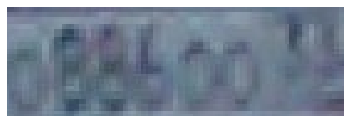

Rotated img:


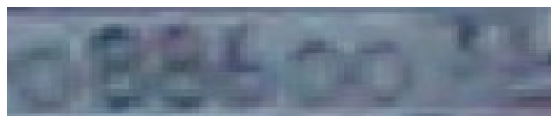

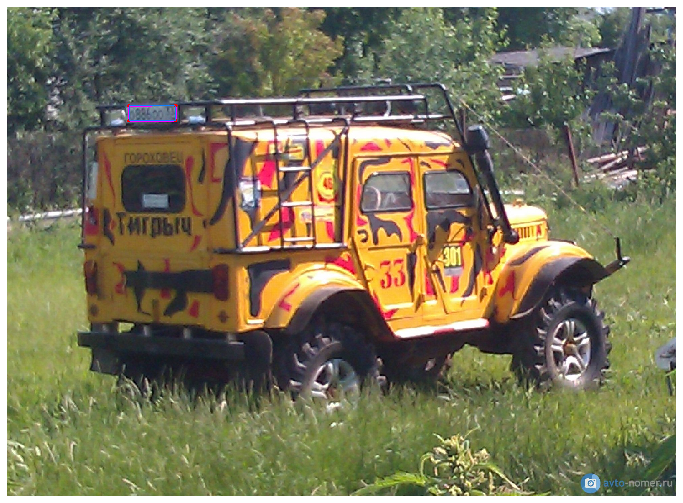

{'boxes': tensor([[365.7229, 297.0464, 501.5880, 341.8588],
         [350.7248, 429.4022, 515.4443, 474.6572],
         [325.9609, 620.7515, 571.7598, 696.2031]], device='cuda:0'),
 'labels': tensor([1, 1, 1], device='cuda:0'),
 'scores': tensor([0.6182, 0.5522, 0.0533], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           .

In [14]:
visualize_prediction_plate("./data/test/1500.jpg", model, id_to_name={1: 'plate'}, thresh=0.6)

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [9]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []
    max_score = -1

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        max_score = i if score > prediction['scores'][max_score] else max_score

        if score > THRESHOLD_SCORE:            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })
        
    k = 1
    
    x_min, y_min, x_max, y_max = map(int, prediction['boxes'][max_score].tolist())
    label = int(prediction['labels'][max_score].cpu())
    score = float(prediction['scores'][max_score].cpu())
    mask = prediction['masks'][max_score][0, :, :].cpu().numpy()
    while not len(pred['nums']):
        
        if (THRESHOLD_SCORE - (k*0.05)) < 0.5:
            print(pred['file'], score)
            break
        if score > (THRESHOLD_SCORE-(k*0.05)):
            print(pred['file'])
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })
        k+=1

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  0%|          | 0/3188 [00:00<?, ?it/s]/home/nasorokin11/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  1%|▏         | 45/3188 [00:05<05:40,  9.22it/s]

./data/test/2411.jpg


  5%|▍         | 153/3188 [00:17<06:13,  8.12it/s]

./data/test/1536.jpg


  5%|▍         | 156/3188 [00:18<05:56,  8.50it/s]

./data/test/2237.jpg 0.3561279773712158


  6%|▌         | 179/3188 [00:20<04:47, 10.48it/s]

./data/test/2140.bmp


  6%|▌         | 185/3188 [00:21<04:57, 10.09it/s]

./data/test/1143.jpg


 12%|█▏        | 392/3188 [00:43<04:14, 10.97it/s]

./data/test/797.bmp


 19%|█▉        | 600/3188 [01:06<05:46,  7.47it/s]

./data/test/1087.bmp 0.19833365082740784


 19%|█▉        | 602/3188 [01:06<05:11,  8.31it/s]

./data/test/1024.jpg


 25%|██▌       | 806/3188 [01:29<04:50,  8.19it/s]

./data/test/1006.jpg


 29%|██▉       | 931/3188 [01:43<04:10,  9.00it/s]

./data/test/899.jpg


 33%|███▎      | 1038/3188 [01:54<03:40,  9.76it/s]

./data/test/874.jpg


 38%|███▊      | 1209/3188 [02:14<03:38,  9.08it/s]

./data/test/2203.jpg


 40%|████      | 1279/3188 [02:21<03:20,  9.51it/s]

./data/test/1313.bmp 0.07859823852777481


 45%|████▌     | 1449/3188 [02:40<02:50, 10.18it/s]

./data/test/2106.bmp


 47%|████▋     | 1509/3188 [02:47<03:41,  7.59it/s]

./data/test/1337.png


 48%|████▊     | 1520/3188 [02:49<03:15,  8.55it/s]

./data/test/992.jpg


 52%|█████▏    | 1658/3188 [03:05<02:35,  9.81it/s]

./data/test/244.bmp 0.07859823852777481


 54%|█████▎    | 1709/3188 [03:10<02:36,  9.44it/s]

./data/test/1610.bmp


 57%|█████▋    | 1814/3188 [03:22<02:46,  8.25it/s]

./data/test/2646.jpeg


 59%|█████▊    | 1869/3188 [03:28<02:18,  9.50it/s]

./data/test/1739.jpg


 60%|█████▉    | 1912/3188 [03:33<02:01, 10.47it/s]

./data/test/166.jpg


 63%|██████▎   | 2006/3188 [03:43<01:50, 10.68it/s]

./data/test/1015.jpeg 0.10248391330242157


 74%|███████▍  | 2358/3188 [04:21<01:32,  8.97it/s]

./data/test/2972.jpg


 74%|███████▍  | 2363/3188 [04:21<01:31,  8.99it/s]

./data/test/185.jpeg


 75%|███████▍  | 2376/3188 [04:23<01:50,  7.37it/s]

./data/test/2463.png


 79%|███████▉  | 2514/3188 [04:39<01:19,  8.44it/s]

./data/test/1277.jpg


 83%|████████▎ | 2651/3188 [04:54<01:19,  6.79it/s]

./data/test/791.jpg
simplify_contour didnt coverege


 84%|████████▎ | 2663/3188 [04:56<01:17,  6.73it/s]

./data/test/2303.jpg 0.48686113953590393


 89%|████████▉ | 2835/3188 [05:15<00:36,  9.78it/s]

./data/test/3054.jpeg 0.4350877106189728


 90%|█████████ | 2871/3188 [05:20<00:42,  7.54it/s]

./data/test/1500.jpg


 94%|█████████▍| 2990/3188 [05:33<00:24,  7.97it/s]

./data/test/2129.jpg


 98%|█████████▊| 3119/3188 [05:48<00:08,  7.69it/s]

./data/test/2926.jpg


In [10]:
len(pred['nums'])

1

# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [11]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None, notbox=False):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                if notbox:
                    ocr_marks.append({
                        'file': file_path,
                        'text': box['text'],
                     })
                else:
                    ocr_marks.append({
                        'file': file_path,
                        'box': np.clip(box['box'], 0, None).tolist(),
                        'text': box['text'],
                        'boxed': False,
                    })

                    # Добавим точки, запакованные в BoundingBox. 
                    # Вместо аугментации rotate. Датасет будет в 2 раза больше

                    #Клипаем, ибо есть отрицательные координаты
                    points = np.clip(box['box'], 0, None) 
                    x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                    x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                    ocr_marks.append({
                        'file': file_path,
                        'box': [x0, y0, x2, y2],
                        'text': box['text'],
                        'boxed': True,
                    })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        self.notbox = notbox
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)
        
        if not self.notbox:
            if item['boxed']:
                x_min, y_min, x_max, y_max = item['box']
                img = img[y_min:y_max, x_min:x_max]
            else:
                points = np.clip(np.array(item['box']), 0, None)
                img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
dop_train_ocr_dataset = OCRDataset(
    marks=dop_train_marks, 
    img_folder="./", 
    alphabet=alphabet,
    transforms=my_ocr_transforms,
    notbox=True
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=4, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

dop_train_ocr_loader = DataLoader(
    dop_train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=4, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=32*8, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [12]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = 512   
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x) 
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        """self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)"""
        layer = nn.TransformerEncoderLayer(input_size, 8,  dim_feedforward=2048,
    dropout=0.3)
        self.transformer = nn.TransformerEncoder(layer, 6)
        #fc_in = hidden_size if not bidirectional else 2 * hidden_size
        
        self.fc = nn.Linear(in_features=input_size,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        """h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)"""
        x = self.transformer(x)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [ ]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnext50_32x4d')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = 2048   
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2,
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [10]:
torch.save(crnn.state_dict(), "GRU_RESNExt")

NameError: name 'crnn' is not defined

### c) Обучаем модель для распознавания текста номера

In [13]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [14]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [15]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(5):
    epoch_losses = []
    print_loss = []
    train_loss = []
    
    crnn.train()
    
    for i, batch in enumerate(tqdm.tqdm(dop_train_ocr_loader, total=len(dop_train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 40 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            train_loss += print_loss
            print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 40 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            train_loss += print_loss
            print_loss = []
            
        
    val_loss = []
    crnn.eval()
    pred_val_dist = []
    targ_val = []
    for j, batch in enumerate(val_ocr_loader):
        if j == 18:
            break

        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        pred_val_dist += decode(seqs_pred, alphabet)
        targ_val += batch["text"]
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )
        val_loss.append(loss.item())
        

    print(epoch, "TRAIN: ", np.mean(train_loss), "VAL: ", np.mean(val_loss), "DIST: ", distance.edit_distance(targ_val, pred_val_dist)/len(targ_val))

 17%|█▋        | 40/232 [00:14<01:02,  3.07it/s]

Loss: 3.2951026


 34%|███▍      | 80/232 [00:27<00:50,  3.01it/s]

Loss: 2.9262939


 52%|█████▏    | 120/232 [00:40<00:37,  2.99it/s]

Loss: 1.3103817


 69%|██████▉   | 160/232 [00:53<00:23,  3.04it/s]

Loss: 0.2560234


 86%|████████▌ | 200/232 [01:07<00:10,  3.05it/s]

Loss: 0.1149675


 21%|██▏       | 40/188 [01:39<03:39,  1.48s/it] 

Loss: 0.9123766


 43%|████▎     | 80/188 [03:19<02:56,  1.63s/it]

Loss: 0.5084885


 64%|██████▍   | 120/188 [04:59<01:46,  1.57s/it]

Loss: 0.1977957


 85%|████████▌ | 160/188 [06:40<00:45,  1.62s/it]

Loss: 0.1644979


  0%|          | 0/232 [00:00<?, ?it/s]          

0 TRAIN:  1.0628397149694324 VAL:  0.14780624624755648 DIST:  0.12955729166666666


 17%|█▋        | 40/232 [00:14<01:03,  3.02it/s]

Loss: 0.3829586


 34%|███▍      | 80/232 [00:27<00:49,  3.04it/s]

Loss: 0.0941637


 52%|█████▏    | 120/232 [00:40<00:36,  3.09it/s]

Loss: 0.0942257


 69%|██████▉   | 160/232 [00:53<00:23,  3.08it/s]

Loss: 0.0946828


 86%|████████▌ | 200/232 [01:07<00:10,  2.95it/s]

Loss: 0.1096529


 21%|██▏       | 40/188 [01:43<03:42,  1.51s/it] 

Loss: 0.3073738


 43%|████▎     | 80/188 [03:25<02:55,  1.62s/it]

Loss: 0.1438761


 64%|██████▍   | 120/188 [05:06<01:48,  1.59s/it]

Loss: 0.1358051


 85%|████████▌ | 160/188 [06:46<00:43,  1.55s/it]

Loss: 0.1303193


  0%|          | 0/232 [00:00<?, ?it/s]          

1 TRAIN:  0.17744459237960375 VAL:  0.13879913546972805 DIST:  0.1169704861111111


 17%|█▋        | 40/232 [00:18<01:20,  2.39it/s]

Loss: 0.2827661


 34%|███▍      | 80/232 [00:35<00:57,  2.64it/s]

Loss: 0.0826146


 52%|█████▏    | 120/232 [00:51<00:38,  2.91it/s]

Loss: 0.0874734


 69%|██████▉   | 160/232 [01:10<00:27,  2.58it/s]

Loss: 0.0831433


 86%|████████▌ | 200/232 [01:24<00:11,  2.89it/s]

Loss: 0.0741463


 21%|██▏       | 40/188 [01:57<04:09,  1.68s/it] 

Loss: 0.2765012


 43%|████▎     | 80/188 [03:44<02:51,  1.59s/it]

Loss: 0.1240194


 64%|██████▍   | 120/188 [05:29<01:48,  1.60s/it]

Loss: 0.1218387


 85%|████████▌ | 160/188 [07:12<00:44,  1.57s/it]

Loss: 0.1124101


  0%|          | 0/232 [00:00<?, ?it/s]          

2 TRAIN:  0.1496034818701446 VAL:  0.13837267272174358 DIST:  0.11219618055555555


 17%|█▋        | 40/232 [00:16<01:10,  2.71it/s]

Loss: 0.2692732


 34%|███▍      | 80/232 [00:30<00:55,  2.72it/s]

Loss: 0.0935836


 52%|█████▏    | 120/232 [00:43<00:37,  3.00it/s]

Loss: 0.0735107


 69%|██████▉   | 160/232 [00:57<00:23,  3.03it/s]

Loss: 0.0913839


 86%|████████▌ | 200/232 [01:10<00:10,  2.91it/s]

Loss: 0.0759285


 21%|██▏       | 40/188 [01:43<04:47,  1.94s/it] 

Loss: 0.2768656


 43%|████▎     | 80/188 [03:20<03:21,  1.87s/it]

Loss: 0.1130743


 64%|██████▍   | 120/188 [04:58<02:05,  1.84s/it]

Loss: 0.1116228


 85%|████████▌ | 160/188 [06:37<00:41,  1.48s/it]

Loss: 0.1097236


  0%|          | 0/232 [00:00<?, ?it/s]          

3 TRAIN:  0.14657741406937225 VAL:  0.14330011068118942 DIST:  0.11675347222222222


 17%|█▋        | 40/232 [00:14<01:03,  3.03it/s]

Loss: 0.2649137


 34%|███▍      | 80/232 [00:27<00:51,  2.94it/s]

Loss: 0.0816411


 52%|█████▏    | 120/232 [00:40<00:37,  2.97it/s]

Loss: 0.0874091


 69%|██████▉   | 160/232 [00:53<00:24,  2.96it/s]

Loss: 0.0877795


 86%|████████▌ | 200/232 [01:07<00:11,  2.87it/s]

Loss: 0.0771302
Epoch    41: reducing learning rate of group 0 to 1.5000e-04.


 21%|██▏       | 40/188 [01:43<05:26,  2.21s/it] 

Loss: 0.3478345


 43%|████▎     | 80/188 [03:23<03:25,  1.90s/it]

Loss: 0.1092520


 64%|██████▍   | 120/188 [05:03<02:52,  2.54s/it]

Loss: 0.1011169


 85%|████████▌ | 160/188 [06:41<01:14,  2.67s/it]

Loss: 0.0992168


4 TRAIN:  0.15658789996368983 VAL:  0.1382118310365412 DIST:  0.103515625


### d) Наконец, делаем предсказания

In [16]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission.csv', index=False)

Как-то так :)

In [17]:
test = pd.read_csv("submission.csv")

In [18]:
test.iloc[154]

file_name        test/2237.jpg
plates_string              NaN
Name: 154, dtype: object

In [19]:
test.head(20)

,file_name,plates_string
0,test/251.bmp,X234YY35
1,test/389.jpg,K316ME177
2,test/2893.jpg,M544KX46
3,test/2898.jpg,H044PM58 E008KA197
4,test/908.bmp,E040AH35
5,test/1164.jpg,H861XT52
6,test/1423.jpg,H672PX177
7,test/1613.jpg,B494TT64 Y474YY64
8,test/1550.bmp,AH270O35
9,test/2936.bmp,T607BA35


In [16]:
test.head(20)

,file_name,plates_string
0,test/251.bmp,X234YY35
1,test/389.jpg,K316ME177
2,test/2893.jpg,M544KX46
3,test/2898.jpg,H044PM58 E008KA197
4,test/908.bmp,E040AH35
5,test/1164.jpg,H861XT52
6,test/1423.jpg,H672PX177
7,test/1613.jpg,B494TT64 Y474YY64
8,test/1550.bmp,AH27O35
9,test/2936.bmp,T607BA35


In [29]:
test.head(20)

,file_name,plates_string
0,test/251.bmp,X234YY59
1,test/389.jpg,K316ME177
2,test/2893.jpg,M544KX46
3,test/2898.jpg,H044PM58 E008KA197
4,test/908.bmp,E040AH35
5,test/1164.jpg,H861XT52
6,test/1423.jpg,H672PX177
7,test/1613.jpg,B494TT64 Y474YY64
8,test/1550.bmp,AH277O35
9,test/2936.bmp,T607BA35


In [6]:
numbers = "1234567890"

In [7]:
test.head(20)

,file_name,plates_string
0,test/251.bmp,X234YY35
1,test/389.jpg,K316ME177
2,test/2893.jpg,M544KX46
3,test/2898.jpg,H044PM58 E008KA197
4,test/908.bmp,E040AH35
5,test/1164.jpg,H861XT52
6,test/1423.jpg,H672PX177
7,test/1613.jpg,B494TT64 Y474YY64
8,test/1550.bmp,AH271O35
9,test/2936.bmp,T607BA35


In [30]:
test[test["file_name"] == "test/296.bmp"]

,file_name,plates_string
3020,test/296.bmp,T767PY35


In [21]:
for i in range(test.shape[0]):
    try:
        ns = test["plates_string"][i].split(" ")
        for n in ns:
            if len(n) > 9 or len(n) < 7:
                print(test["file_name"][i], n)
    except:
        pass
        """print(test["file_name"][i])"""
        

test/1039.bmp B4HB35
test/2203.jpg O555HA1124


In [19]:
for i in range(test.shape[0]):
    try:
        ns = test["plates_string"][i].split(" ")
        for n in ns:
            if len(n) > 9 or len(n) < 7:
                print(test["file_name"][i], n)
    except:
        pass
        """print(test["file_name"][i])"""
        

test/3023.jpg B25X27
test/797.bmp B6Y35
test/549.jpg B4X159
test/1400.jpg C35P7
test/1975.jpg O0OH98
test/1071.jpg X25PK5
test/118.jpg B9C99
test/1677.jpg T8BB35
test/3123.bmp A32M35
test/2027.jpg X097YHH135
test/3091.jpg B00Y35
test/1830.jpg A2A199
test/2063.jpg H01PK5
test/525.jpg E2828YE199
test/997.png AX0B0
test/997.png A440B8
test/296.bmp T7PY35
test/2311.jpg H688X3


In [31]:
for i in range(test.shape[0]):
    if test["plates_string"][i] != test["plates_string"][i]:
        print(test["file_name"][i])

test/2237.jpg
test/1087.bmp
test/1313.bmp
test/244.bmp
test/1015.jpeg
test/2303.jpg
test/3054.jpeg


Class: plate, Confidence: 0.8902817964553833
Bounding box:


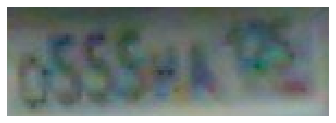

Rotated img:


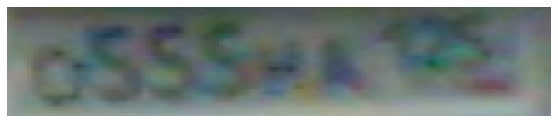

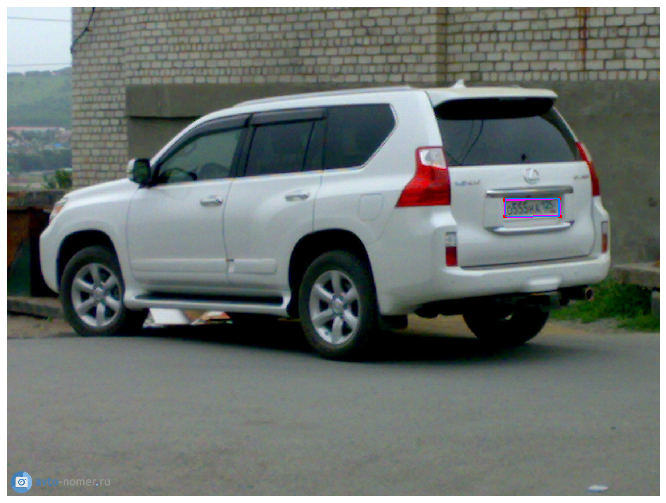

{'boxes': tensor([[1373.8104,  529.9688, 1521.9513,  579.3115]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.8903], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}

In [33]:
visualize_prediction_plate("./data/test/2203.jpg", model, id_to_name={1: 'plate'}, thresh=0.6)

In [20]:
cv2.imread(img_path)